# Collaborative filtering deep dive 


Movie dataset and we want to recommend movies to some people but we don't really know what does the movie mean in model so we have to engineer the features which we are going to use 

In [1]:
!pip install fastbook 


     |████████████████████████████████| 727kB 26.7MB/s 
     |████████████████████████████████| 194kB 54.2MB/s 
     |████████████████████████████████| 1.2MB 38.7MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
     |████████████████████████████████| 61kB 10.9MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
import fastbook 
from fastai import * 
from fastai.tabular.all import * 
from fastai.collab import * 

In [3]:
path = untar_data(URLs.ML_100k)

In [4]:
ratings = pd.read_csv(path/'u.data',delimiter = '\t', header = None , names = ['user', 'movie', 'rating', 'timestamp'])

In [5]:
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# learning the latent factors 


for our model to learn from data we have to create some latent factors which willl help the model to recommend movie 

1. Gradient Descent approach : 
  Initally randomly arrange some parameters this parameters are set from some latent factors such as user and movies 

  because of each user will have some number with the help of latent factors associated with him simliarly each movie will have set of latent factor associated with it 

# let's first create the data loaders 

In [6]:
movies = pd.read_csv(path/'u.item',delimiter = '|',encoding = 'latin-1', 
                     usecols = (0,1), names = ('movie', 'title'), header = None  )

merging this movies column with the ratings column

In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


# Building the dataset from pd DataFrmae

In [8]:
dls = CollabDataLoaders.from_df(ratings , item_name = 'title', bs = 64)

In [9]:
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [10]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])

In [11]:
n_factors = 5 

In [12]:
 user_factors = torch.randn(n_users, n_factors) 
 movie_factors = torch.randn(n_movies , n_factors )

In [13]:
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [14]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [15]:
class Example: 
  def __init__(self, a): self.a = a 
  def say(self,x): return f'hello {self.a} , {x}'


In [16]:
ex = Example('som')

In [17]:
ex.say('nice to meet u')

'hello som , nice to meet u'

# Making the dot product with the help of pytorch module 

In [18]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors)
  
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return (users*movies).sum(dim = 1)

In [19]:
x,y = dls.one_batch()

In [20]:
x.shape

torch.Size([64, 2])

In [21]:
model = DotProduct(n_users, n_movies, 50) 
learn = Learner(dls, model , loss_func = MSELossFlat())


In [22]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:06
1,1.093331,1.109981,00:06
2,0.958258,0.990199,00:06
3,0.814234,0.894916,00:06
4,0.780714,0.882022,00:06


to make the model little bit easier we can pass the range and make the loss to sigmoid with range 


In [23]:
class DotProduct(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range= (0.,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.movie_factors = Embedding(n_movies, n_factors) 
    self.y_range = y_range
  
  def forward(self, x ):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    return sigmoid_range((users*movies).sum(dim =1), *self.y_range)


In [24]:
model = DotProduct(n_users,n_movies, 50 ) 
learn = Learner(dls, model , loss_func = MSELossFlat()) 
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:06
1,0.878134,0.918898,00:06
2,0.675850,0.875467,00:06
3,0.483372,0.877939,00:06
4,0.378927,0.881887,00:06


In [25]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = Embedding(n_users, n_factors)
    self.user_bias = Embedding(n_users, 1)
    self.movie_factors = Embedding(n_movies, n_factors)
    self.movie_bias = Embedding(n_movies, 1)
    self.y_range = y_range
  def forward(self, x):
    users = self.user_factors(x[:,0])
    movies = self.movie_factors(x[:,1])
    res = (users * movies).sum(dim=1, keepdim=True)
    res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
    return sigmoid_range(res, *self.y_range)

In [26]:
model = DotProductBias(n_users,n_movies, 50)
learn = Learner(dls, model , loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:07
1,0.846664,0.865633,00:07
2,0.608090,0.865127,00:07
3,0.413482,0.887318,00:07
4,0.286971,0.894876,00:07


# weight decay 
instead of improving the model it's getting worse so we can see that the model is overfitting to avoid this we should add weight decay to it 

In [27]:
# parameters.grad += wd * 2 * parameters 

In [28]:
class T(Module): 
  def __init__(self): self.a = torch.ones(3)

L(T().parameters())

(#0) []

pytorch does not learn everything which is avialable in the module for telling pytorch to learn we have to pass it through `nn.Parameter()`

In [29]:
class T(Module):
  def __init__(self): self.a = nn.Parameter(torch.ones(3))

L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

randomly initializgin the praameters 

In [30]:
def create_params(size):
  return nn.Parameter(torch.zeros(*size).normal_(0,0.01))

using the dot product without embedding 

In [31]:
class DotProductBias(Module):
  def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
    self.user_factors = create_params([n_users,n_factors])
    self.user_bias = create_params([n_users])
    self.movie_factors = create_params([n_movies, n_factors])
    self.movie_bias = create_params([n_movies])
    self.y_range = y_range

  def forward(self, x ):
    users = self.user_factors[x[:,0]]
    movies = self.movie_factors[x[:,1]]
    res = (users*movies).sum(dim = 1)
    res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
    return sigmoid_range(res, *self.y_range)

In [32]:
model = DotProductBias(n_users,n_movies,50)
learn = Learner(dls, model , loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3,wd = 0.1)

epoch,train_loss,valid_loss,time
0,0.925958,0.956361,00:07
1,0.884023,0.881761,00:08
2,0.759123,0.833969,00:08
3,0.591400,0.825345,00:07
4,0.492688,0.825909,00:08


## interpreting embedding and biases 

In [33]:
print('hello')

hello


In [34]:
movie_bias = learn.model.movie_bias.squeeze()
idxs= movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Crow: City of Angels, The (1996)',
 'Robocop 3 (1993)',
 'Man of the House (1995)']

In [35]:
idxs = movie_bias.argsort(descending = True)[:5]
[dls.classes['title'][i] for i in idxs ]

['L.A. Confidential (1997)',
 "Schindler's List (1993)",
 'Silence of the Lambs, The (1991)',
 'Titanic (1997)',
 'Star Wars (1977)']

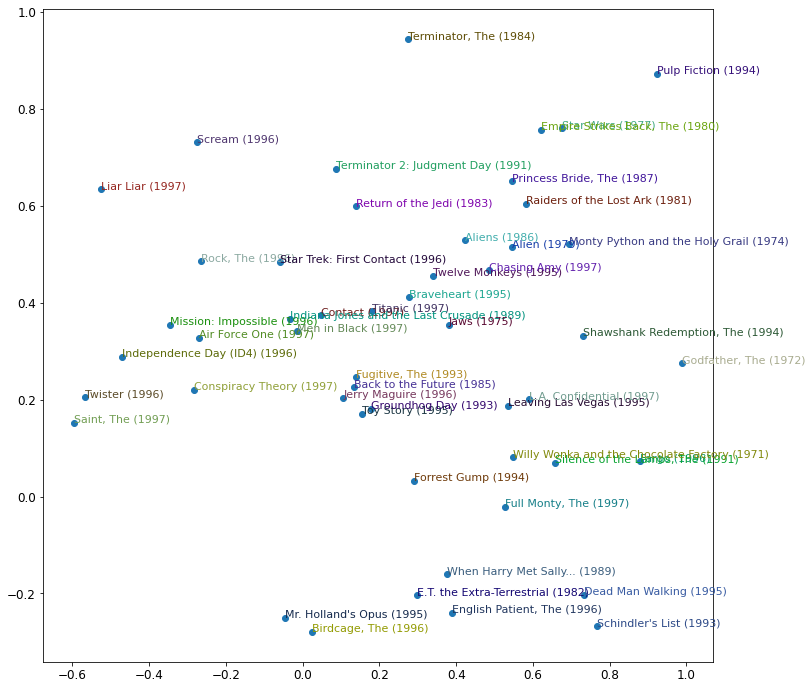

In [36]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

# collab learner fast ai 


In [37]:
learn = collab_learner(dls, n_factors = 50, y_range = (0,5.5))
learn.fit_one_cycle(5, 5e-3)


epoch,train_loss,valid_loss,time
0,0.917238,0.940713,00:07
1,0.835835,0.871023,00:07
2,0.611013,0.875085,00:07
3,0.416684,0.896842,00:07
4,0.286377,0.902852,00:07


In [38]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [40]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending = True)[:5]
[dls.classes['title'][i] for i in idxs ]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

# Embedding distances 


In [48]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors,movie_factors[idx][None])
idx = distances.argsort(descending = True)[1]
dls.classes['title'][idx]

# movie_factors = learn.model.i_weight.weight
# idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
# distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
# idx = distances.argsort(descending=True)[1]
# dls.classes['title'][idx]

'Go Fish (1994)'

In [49]:
print('hello world')

hello world


In [50]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [51]:
class CollabNN(Module):
  def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
    self.user_factors = Embedding(*user_sz)
    self.item_factors = Embedding(*item_sz)
    self.layers = nn.Sequential(
    nn.Linear(user_sz[1]+item_sz[1], n_act),
    nn.ReLU(),
    nn.Linear(n_act, 1))
    self.y_range = y_range
  def forward(self, x):
    embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
    x = self.layers(torch.cat(embs, dim=1))

In [52]:
model = CollabNN(*embs)

In [54]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time


AttributeError: ignored

In [55]:
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.979147,0.965175,00:08
1,0.922855,0.924356,00:08
2,0.852667,0.891639,00:08
3,0.818609,0.858544,00:08
4,0.780675,0.861305,00:08


In [57]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
  def __init__(self, emb_szs, layers, **kwargs):
    super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

# Bootstraping problem in collaborative filtering model